# Particle Image Velocimetry (PIV)

PIV is an imaging technique to measure the instantaneous velocity distribution within a plane, this can be defined by a laser light sheet, water surface, etc. It achieves this by dividing the images into interrogation windows and local displacement vectors are determined for each region by cross correlating windows between frames; Eularian technique (fixed frame of reference and grid).  A fundamental difference from PTV is that it finds the velocity vector for a group of particles instead of individual particles.

## Seeding

PIV is very sensitive to seeding. The ideal properties and distribution will differ between fluids but some general examples are:
- for air the seeding particles are commonly oil, 1 to 5 micrometers
- for water the particles are commonly polusterine, poluamid or hollow glass spheres in the ranges 5 to 100 micrometers. 
As a general rule of thumbs 10 to 25 particles per interrogation area are good. 

The dimensions limitations are set by the fact that the particle should be large enough to scatter significant quantity of light to be detected but small enough that the repsonse time of the particles to the motion of the lfuid is reasonably short. Lastly, for 3D PIV particles of equal density to the fluid become very important.

Note that it is not a requirement to introduce tracers one self, foam, algae and other features can work as tracers as well. 

```{figure} ./Data_PIV/drones-03-00014-g002.png
:width: 500px
```

```{figure} ./Data_PIV/drones-03-00014-g004.png
:width: 500px
```

Drone captured image without artificial tracers used to carry out PIV. Calculated flow lines are superimposed and the straight line is a cross-section along which bathymetry will be calculated, the RiVeR software package has similar functions. 


## Data

For resolution ideally each particles should cover 2 to 3 pixels across in an image. Placing an image in a one bit colour scheme can aid particle identification. Alternative a simple grey filter can help too when placing a threshold for the 2 bit image is difficult.

The framerate at which images are collected become significant too:
- A shorter timestep between frames can increase the accuracy for cross-correlation, however if too small no displacement is measured. 
- The timestep constrains the highest measurable velocity, by particles travelling further than the size of the interrogation area within the timestep taken. The result is lost correlation between the two image frames and hence the loss of velocity information.
- A Longer timestep reduces the accuracy for cross-correlation and can even cause it to return spurious values if the interrogation windows have changed too much in pattern. 


## Algorithm

To link the interrogation windows (X) across frames (I) PIV uses a cross-correlation (sliding dot product) algorithm as shown by the equation below:
\\( C(s) = \int \int_IA I_1(X)\cdot I_2(X-s) dX \\) 

This produces a peak at the highest correlation between windows across frames. Accuracy can be improved by sub-pixel interpolation (not included in our script below)

```{figure} Data_PIV/cross-correlation-technique-PIV.png
:width: 500px
```
Having calculated the distance, still in pixels but can be mapped into real distances, and having set the timestep between frames, we can calculate the velocity vectors. 

There are many more sophisticated methods that may require a significant investment of time

# Demonstration

Required package installation:
- pip install cython numpy
- pip install openpiv --pre

or for conda (installs all dependencies too): 
- conda install -c conda-forge openpiv  

In [1]:
#import required libraries
from openpiv import tools, process, validation, filters, scaling 
import numpy as np
import matplotlib.pyplot as plt
import imageio
%matplotlib inline

In [2]:
# read in frames; .tif format common to avoid dataloss
# very memory intensive file format however
frame_a  = tools.imread( 'Data_PIV/B001_1.tif' )
frame_b  = tools.imread( 'Data_PIV/B001_2.tif' )

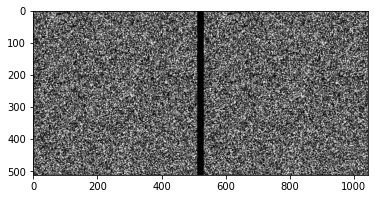

In [3]:
# visualise frames, can visually check if timestep is big enough to see change
plt.imshow(np.c_[frame_a,np.ones((frame_a.shape[0],20)),frame_b],cmap=plt.cm.gray)

In [4]:
# set parameters
# resolution low enough to avoid noise / lost correlation

#size of window over which to take pattern
winsize = 32 # pixels

#window size over which above pattern is searched in frame 2 
searchsize = 64  # pixels, search in image B
overlap = 12 # pixels

#time between frames
dt = 0.02 # sec

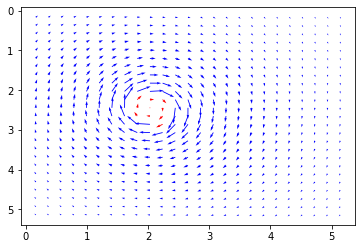

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x29aef8313c8>)

In [5]:
# PIV functions, can be found in the GITHUB repository cited
u0, v0, sig2noise = process.extended_search_area_piv( frame_a.astype(np.int32), frame_b.astype(np.int32), window_size=winsize, overlap=overlap, dt=dt, search_area_size=searchsize, sig2noise_method='peak2peak' )
x, y = process.get_coordinates( image_size=frame_a.shape, window_size=winsize, overlap=overlap )
u1, v1, mask = validation.sig2noise_val( u0, v0, sig2noise, threshold = 1.3 )
u2, v2 = filters.replace_outliers( u1, v1, method='localmean', max_iter=10, kernel_size=2)
x, y, u3, v3 = scaling.uniform(x, y, u2, v2, scaling_factor = 96.52 )
# save output and display
tools.save(x, y, u3, v3, mask, 'exp1_001.txt' )
tools.display_vector_field('exp1_001.txt', scale=80, width=0.0025)

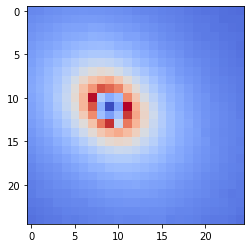

In [6]:
# Calculate the magnitude of each vector
mag = np.empty([np.shape(x)[0],np.shape(x)[1]])
for i in range(np.shape(x)[0]):
    for j in range(np.shape(x)[1]):
        mag[i][j] = np.sqrt(u3[i][j]**2 + v3[i][j]**2)
# Show magntude map
_ = plt.imshow(mag,cmap=plt.cm.get_cmap('coolwarm')) 

# Recursive PIV

To achieva a finer resolution and avoid a lot of spurious values we can take a recursive approach using the results from our previous step as an initial model and refine this with a shrinking interrogation and search window in each step to increase our resolution. See cited paper for further information. Simple example shown below.

In [7]:
# additional required libraries
from openpiv import pyprocess
from pylab import *
from skimage import img_as_uint

In [35]:
x4,y4,u4,v4, mask = process.WiDIM(frame_a.astype(np.int32), frame_b.astype(np.int32), ones_like(frame_a).astype(np.int32),
                min_window_size=32, overlap_ratio=0.25, coarse_factor=0, dt=0.1, validation_method='mean_velocity', 
                trust_1st_iter=0, validation_iter=0, tolerance=0.7, nb_iter_max=1, sig2noise_method='peak2peak')
tools.save(x4, y4, u4, v4, zeros_like(u4), 'Y4-S3_Camera000398_widim1.txt' )

----------------------------------------------------------
|----->     ||   The Open Source  P article              |
| Open      ||                    I mage                 |
|     PIV   ||                    V elocimetry  Toolbox  |
|     <-----||   www.openpiv.net          version 1.0    |
----------------------------------------------------------
 
('Algorithm : ', 'WiDIM')
 
Parameters   
-----------------------------------
('     ', 'Size of image', ' | ', [512, 512])
('     ', 'total number of iterations', ' | ', 1)
('     ', 'overlap ratio', ' | ', 0.25)
('     ', 'coarse factor', ' | ', 0)
('     ', 'time step', ' | ', 0.10000000149011612)
('     ', 'validation method', ' | ', 'None')
('     ', 'number of validation iterations', ' | ', 0)
('     ', 'subpixel_method', ' | ', 'gaussian')
('     ', 'Nrow', ' | ', array([21]))
('     ', 'Ncol', ' | ', array([21]))
('     ', 'Window sizes', ' | ', array([32]))
-----------------------------------
|           STARTING              |

In [36]:
x5,y5,u5,v5, mask = process.WiDIM(frame_a.astype(np.int32), frame_b.astype(np.int32), ones_like(frame_a).astype(np.int32), 
                min_window_size=16, overlap_ratio=0.25, coarse_factor=2, dt=0.1, validation_method='mean_velocity', 
                trust_1st_iter=1, validation_iter=2, tolerance=0.7, nb_iter_max=4, sig2noise_method='peak2peak')
tools.save(x5, y5, u5, v5, zeros_like(u5), 'Y4-S3_Camera000398_widim2.txt' )

----------------------------------------------------------
|----->     ||   The Open Source  P article              |
| Open      ||                    I mage                 |
|     PIV   ||                    V elocimetry  Toolbox  |
|     <-----||   www.openpiv.net          version 1.0    |
----------------------------------------------------------
 
('Algorithm : ', 'WiDIM')
 
Parameters   
-----------------------------------
('     ', 'Size of image', ' | ', [512, 512])
('     ', 'total number of iterations', ' | ', 4)
('     ', 'overlap ratio', ' | ', 0.25)
('     ', 'coarse factor', ' | ', 2)
('     ', 'time step', ' | ', 0.10000000149011612)
('     ', 'validation method', ' | ', 'mean_velocity')
('     ', 'number of validation iterations', ' | ', 2)
('     ', 'subpixel_method', ' | ', 'gaussian')
('     ', 'Nrow', ' | ', array([10, 21, 42, 42]))
('     ', 'Ncol', ' | ', array([10, 21, 42, 42]))
('     ', 'Window sizes', ' | ', array([64, 32, 16, 16]))
--------------------------

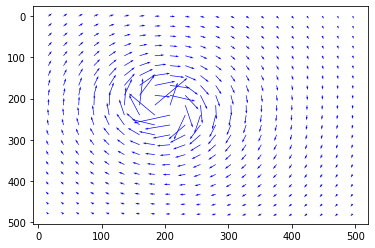

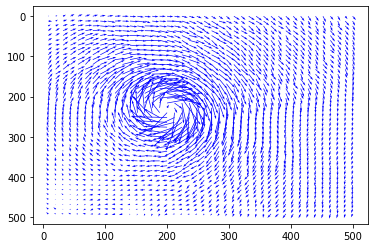

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x29af34b2a90>)

In [37]:
tools.display_vector_field('Y4-S3_Camera000398_widim1.txt', widim=True, scale=900, width=0.002,scaling_factor=96.52)
tools.display_vector_field('Y4-S3_Camera000398_widim2.txt', widim=True, scale=900, width=0.002,scaling_factor=96.52)

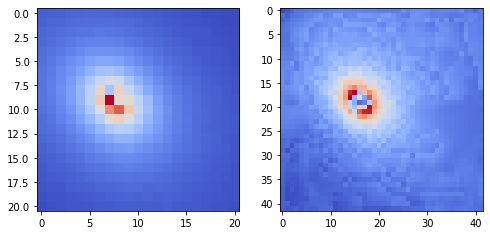

In [38]:
fig = plt.figure(figsize=(8,8))

fig.add_subplot(121)
mag = np.empty([shape(x4)[0],shape(x4)[1]])
for i in range(shape(x4)[0]):
    for j in range(shape(x4)[1]):
        mag[i][j] = np.sqrt(u4[i][j]**2 + v4[i][j]**2)
plt.imshow(mag,cmap=plt.cm.get_cmap('coolwarm'))

fig.add_subplot(122)
mag = np.empty([shape(x5)[0],shape(x5)[1]])
for i in range(shape(x5)[0]):
    for j in range(shape(x5)[1]):
        mag[i][j] = np.sqrt(u5[i][j]**2 + v5[i][j]**2)
plt.imshow(mag,cmap=plt.cm.get_cmap('coolwarm'))
plt.show()

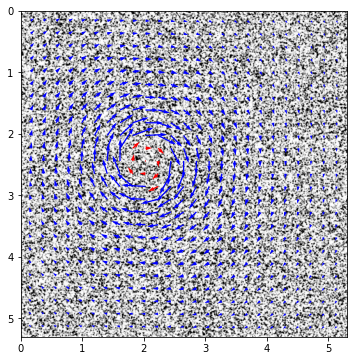

In [39]:
# Overlap on original image
fig, ax = plt.subplots(figsize=(6,6))
tools.display_vector_field('exp1_001.txt', ax=ax, scaling_factor=96.52, scale=50, width=0.004, on_img=True, image_name='Data_PIV/B001_1.tif');

## Overview

Positives:
- non-intrusive except if tracers are used
- sub-pixel displacement values allow a high degree of accuracy since each vector is a statistical average for many particles within a particular window

Drawbacks:
- very sensitive to seeding parameters
- uncertainties near walls. Hence correlation with PTV or only PTV evaluation should be applied below half an interrogation window from the wall
- in 2D can cause problems with the z-axis component
- particles may not always follow the flow appropiately 

## Applications

some examples between many:
- study aerodynamics for plane wings, cars, etc. 
- verifying CFD models in small and large scale, even medically to study the behaviour of a coardiopulmanary bypass
- granular PIV: velocity measurement in grnular flows and avalanches
- Large Scale PIV: can be used with sattelite imagery or drone imagery and requires no tracers

# References And Useful Reading
- Data: http://www.pivchallenge.org
- PIV challenge, pushing the limits: https://link.springer.com/article/10.1007/s00348-005-0951-2
- OpenPIV python documentation: https://buildmedia.readthedocs.org/media/pdf/openpiv/latest/openpiv.pdf
- OpenPIV repository: https://github.com/alexlib/openpiv-python
- OpenPIV website: http://www.openpiv.net
- LSPIV UAV: https://www.mdpi.com/2504-446X/3/1/14#
- Seeding 1 : https://www.thermofisher.com/order/catalog/product/2005ATS
- Seeding 2 : https://www.sciencedirect.com/science/article/pii/S0894177712003135?via%3Dihub
- Super resoltuion PIV by recursive local-correlation: https://www.semanticscholar.org/paper/Super-resolution-PIV-by-recursive-local-correlation-Hart/543dd09f0700b9dcf0bf1e6be53db61396ade9cf
- PIV/PTV near walls:	https://link.springer.com/article/10.1007/s00348-012-1307-3
- RiVeR toolbox: http://10.0.3.248/j.cageo.2017.07.009
- PIVLaB, great to play around with a GUI: https://uk.mathworks.com/matlabcentral/fileexchange/27659-pivlab-particle-image-velocimetry-piv-tool
- Correlation Image: https://www.researchgate.net/figure/Block-matching-cross-correlation-technique-typically-used-in-PIV-The-position-of-the_fig1_321974432

 

